In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

# Monet-Style Image Generation using CycleGAN¶


The goal is to develop and train a Generative Adversarial Network (GAN) model that can produce images in the artistic style of Claude Monet. This could involve transforming existing photographs into Monet’s style or generating entirely new images that emulate his distinctive brushstrokes, color palettes, and overall aesthetic

We will implement a CycleGAN, a type of GAN particularly suited for image-to-image translation tasks where paired training data (e.g., a photo and its exact Monet-style equivalent) is not available. A CycleGAN learns mappings between two distinct image domains (in our case, landscape photographs and Monet paintings) using two generators and two discriminators.

Generator G: Learns to translate photos into Monet-style paintings
Generator F: Learns to translate Monet paintings back into photos 
Discriminator D_Y: Tries to distinguish between real Monet paintings and generated (fake) Monet paintings.
Discriminator D_X: Tries to distinguish between real photos and generated (fake) photos.

Dataset: The competition offers two main image sets:

- Monet Paintings: ~300 images (monet_jpg, monet_tfrec) for training the model on Monet’s style.
- Photos: ~7000 landscape photos (photo_jpg, photo_tfrec) to be transformed into Monet style for submission.

Evaluation Metric: Submissions are evaluated using the Memorization-informed Fréchet Inception Distance (MiFID) score.

# Imports


In [2]:
# --- Imports ---
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import zipfile
from tqdm.notebook import tqdm


# Data Paths (Kaggle)
BASE_PATH = '/kaggle/input/gan-getting-started/'

MONET_TFREC_PATH = os.path.join(BASE_PATH, 'monet_tfrec')
PHOTO_TFREC_PATH = os.path.join(BASE_PATH, 'photo_tfrec')
MONET_JPG_PATH = os.path.join(BASE_PATH, 'monet_jpg')
PHOTO_JPG_PATH = os.path.join(BASE_PATH, 'photo_jpg')

# Model & Training Params
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
BUFFER_SIZE = 200 # For shuffling dataset
BATCH_SIZE = 1
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE

# Loss weights
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 0.5

# Output directory for generated images
OUTPUT_DIR = "/kaggle/working/images/"
ZIP_FILENAME = "/kaggle/working/images.zip"

2025-06-07 23:31:31.992409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749339092.286429      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749339092.370617      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploratory Data Analysis (EDA)¶


Number of Monet JPG files found: 300
Number of Photo JPG files found: 7038
Number of Monet TFRecord files found: 5
Number of Photo TFRecord files found: 20


2025-06-07 23:31:49.801842: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


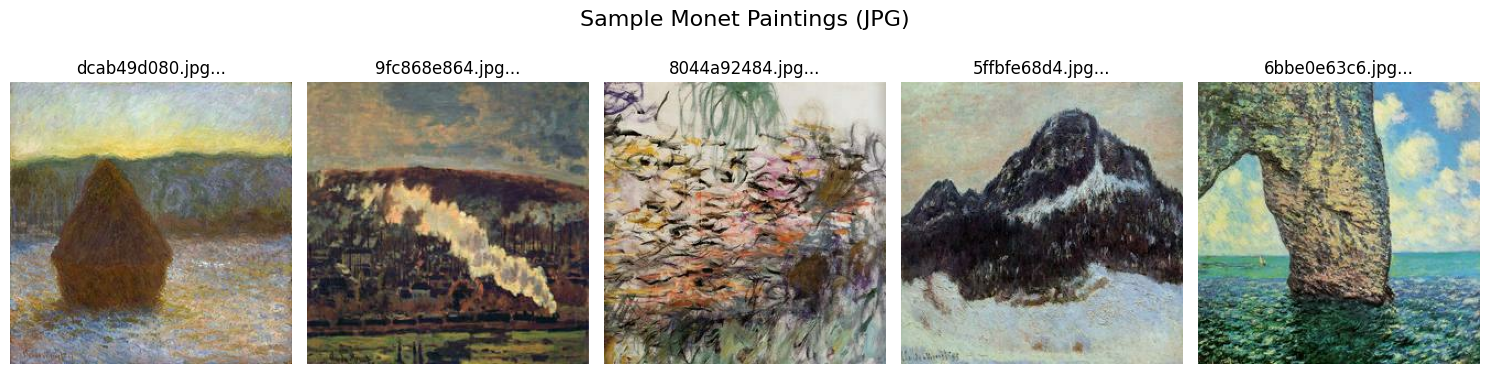

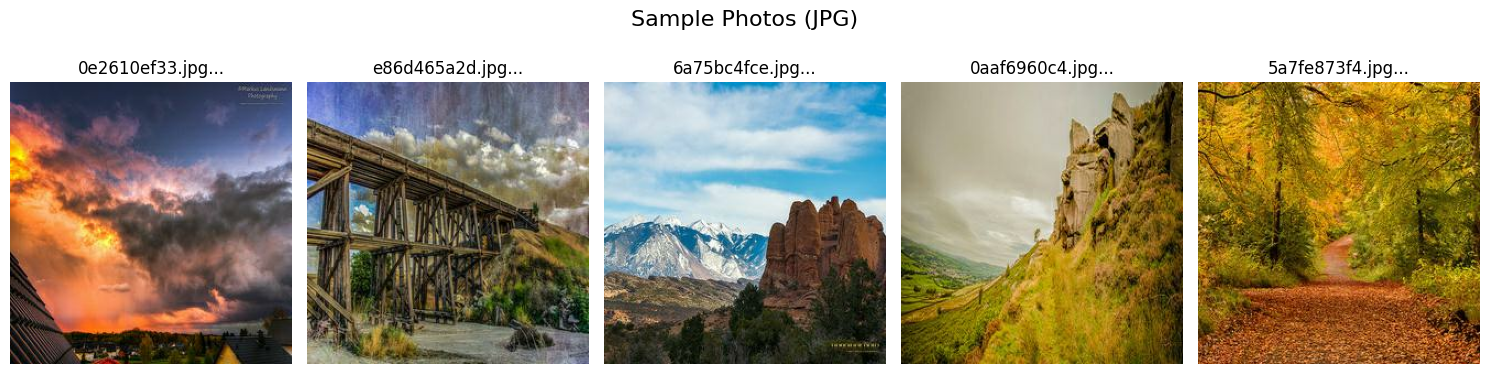

In [3]:
# --- Inspection ---

# List files and count
monet_jpg_files = os.listdir(MONET_JPG_PATH)
photo_jpg_files = os.listdir(PHOTO_JPG_PATH)
print(f"Number of Monet JPG files found: {len(monet_jpg_files)}")
print(f"Number of Photo JPG files found: {len(photo_jpg_files)}")

# List TFRecord files
monet_tfrec_files = tf.io.gfile.glob(os.path.join(MONET_TFREC_PATH, '*.tfrec'))
photo_tfrec_files = tf.io.gfile.glob(os.path.join(PHOTO_TFREC_PATH, '*.tfrec'))
print(f"Number of Monet TFRecord files found: {len(monet_tfrec_files)}")
print(f"Number of Photo TFRecord files found: {len(photo_tfrec_files)}")


# --- Visualization ---
 
# Function to display sample images
def display_samples(image_paths, num_samples=5, title="Sample Images"):

    plt.figure(figsize=(15, 4))
    plt.suptitle(title, fontsize=16)
    random_indices = random.sample(range(len(image_paths)), min(num_samples, len(image_paths)))

    for i, idx in enumerate(random_indices):
        img_path = image_paths[idx]
        plt.subplot(1, num_samples, i + 1)
        img_raw = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        plt.imshow(img)
        plt.title(os.path.basename(img_path)[:15]+"...") # Show start of filename
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Get full paths for visualization
monet_jpg_fullpaths = [os.path.join(MONET_JPG_PATH, f) for f in monet_jpg_files if f.lower().endswith('.jpg')]
photo_jpg_fullpaths = [os.path.join(PHOTO_JPG_PATH, f) for f in photo_jpg_files if f.lower().endswith('.jpg')]

# Display samples if paths exist
display_samples(monet_jpg_fullpaths, num_samples=5, title="Sample Monet Paintings (JPG)")
display_samples(photo_jpg_fullpaths, num_samples=5, title="Sample Photos (JPG)")

# EDA Summary and Preprocessing Discussion¶

# Data Loading and Preprocessing Pipeline


--- Loading Datasets ---
Number of Monet samples (from TFRecords): 300
Number of Photo samples (from TFRecords): 7038
Calculated steps per epoch: 150

Monet dataset element spec: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Photo dataset element spec: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Combined training dataset element spec: (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))


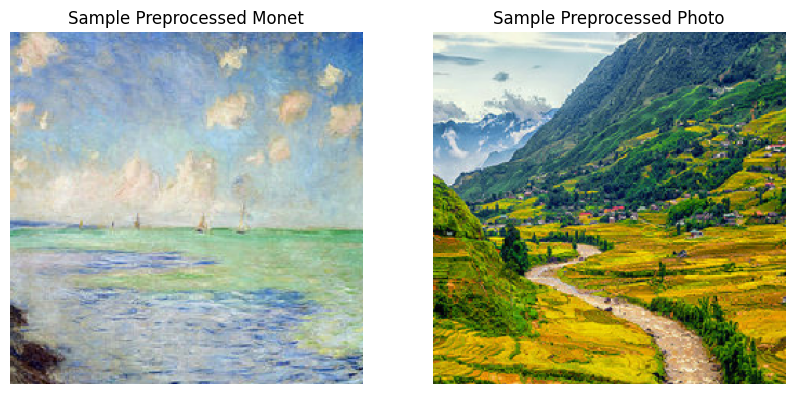

In [4]:
# --- TFRecord Parsing and Preprocessing Functions ---

def decode_tfrecord(record_bytes):
    """Parses a single TFRecord and decodes the JPEG image."""
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string)
    })
    image = tf.io.decode_jpeg(features['image'], channels=3)
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    # Cast to float32 for normalization
    image = tf.cast(image, tf.float32)
    return image

def normalize_image(image):
    """Normalizes image pixel values to the range [-1, 1]."""
    image = (image / 127.5) - 1.0
    return image

def random_jitter(image):
    """Applies random jitter: resizing and random cropping."""
    # Resize to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Randomly crop to 256 x 256 x 3
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    # Random mirroring
    image = tf.image.random_flip_left_right(image)
    return image

def preprocess_image_train(image):
    """Applies jitter and normalization for training."""
    image = random_jitter(image)
    image = normalize_image(image)
    return image

def preprocess_image_test(image):
    """Applies only normalization for testing/generation."""
    image = normalize_image(image)
    return image


# --- Dataset Creation Function ---

def load_dataset(tfrecord_files, train=True, shuffle=True):
    """Creates a tf.data.Dataset from TFRecord files."""
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    # Map decoding and preprocessing
    if train:
        dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    else: # For generation/testing, don't apply jitter
        dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
        dataset = dataset.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

# --- Load the Datasets ---
print("\n--- Loading Datasets ---")
monet_ds = load_dataset(monet_tfrec_files, train=True, shuffle=True)
photo_ds = load_dataset(photo_tfrec_files, train=True, shuffle=True)

# Combine datasets for paired iteration during training
full_dataset = tf.data.Dataset.zip((monet_ds.repeat(), photo_ds.repeat()))

def count_data_items(filenames):
    """Counts the total number of records across TFRecord files."""
    n = [int(tf.data.TFRecordDataset(fn).reduce(np.int64(0), lambda x, _: x + 1)) for fn in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(monet_tfrec_files)
n_photo_samples = count_data_items(photo_tfrec_files)
print(f"Number of Monet samples (from TFRecords): {n_monet_samples}")
print(f"Number of Photo samples (from TFRecords): {n_photo_samples}")

# Determine steps per epoch based on the larger dataset size for CycleGAN
steps_per_epoch = 150 # max(n_monet_samples, n_photo_samples) // BATCH_SIZE
print(f"Calculated steps per epoch: {steps_per_epoch}")


print(f"\nMonet dataset element spec: {monet_ds.element_spec}")
print(f"Photo dataset element spec: {photo_ds.element_spec}")
print(f"Combined training dataset element spec: {full_dataset.element_spec}")

# Visualize one preprocessed sample from each dataset
sample_monet_batch = next(iter(monet_ds))
sample_photo_batch = next(iter(photo_ds))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow((sample_monet_batch[0].numpy() + 1.0) * 0.5)
plt.title("Sample Preprocessed Monet")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow((sample_photo_batch[0].numpy() + 1.0) * 0.5)
plt.title("Sample Preprocessed Photo")
plt.axis('off')
plt.show()


# Model Architecture (CycleGAN)¶


In [5]:
# --- Model Architecture Components ---

# Fallback to LayerNormalization
NormalizationLayer = lambda: layers.LayerNormalization(axis=[1, 2])


# --- Building Blocks ---
def downsample(filters, size, apply_norm=True, name=None):
    """Downsampling block: Conv2D -> Norm -> LeakyReLU"""
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential(name=name)
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(NormalizationLayer())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False, name=None):
    """Upsampling block: Conv2DTranspose -> Norm -> Dropout -> ReLU"""
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential(name=name)
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                       kernel_initializer=initializer, use_bias=False))
    result.add(NormalizationLayer())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

# --- Generator Model (U-Net based) ---
def build_generator(name="generator"):
    """Builds the Generator model (U-Net architecture)."""
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Downsampling path (Encoder)
    down_stack = [
        downsample(64, 4, apply_norm=False, name="down_1"), 
        downsample(128, 4, name="down_2"),                 
        downsample(256, 4, name="down_3"),                 
        downsample(512, 4, name="down_4"),                 
        downsample(512, 4, name="down_5"),                 
        downsample(512, 4, name="down_6"),                 
        downsample(512, 4, name="down_7"),                 
        downsample(512, 4, name="down_8"),
    ]

    # Upsampling path (Decoder)
    up_stack = [
        upsample(512, 4, apply_dropout=True, name="up_1"),
        upsample(512, 4, apply_dropout=True, name="up_2"),
        upsample(512, 4, apply_dropout=True, name="up_3"),
        upsample(512, 4, name="up_4"),                    
        upsample(256, 4, name="up_5"),                    
        upsample(128, 4, name="up_6"),                    
        upsample(64, 4, name="up_7"),                     
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    # Final output layer
    last = layers.Conv2DTranspose(IMG_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh', name="output_image")

    x = inputs
    skips = []
    # Connect encoder to decoder with skip connections
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Build decoder path with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x, name=name)

# --- Discriminator Model (PatchGAN) ---
def build_discriminator(name="discriminator"):
    """Builds the Discriminator model (PatchGAN architecture)."""
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], name='input_image')

    # PatchGAN Structure
    x = downsample(64, 4, False, name="down_1")(inp)
    x = downsample(128, 4, name="down_2")(x)
    x = downsample(256, 4, name="down_3")(x)

    # Add padding before the next convolution
    x = layers.ZeroPadding2D(name="pad_1")(x)
    x = layers.Conv2D(512, 4, strides=1,
                      kernel_initializer=initializer,
                      use_bias=False, name="conv_1")(x)

    # Apply normalization after convolution
    x = NormalizationLayer()(x)
    x = layers.LeakyReLU(name="leaky_relu")(x)

    # Add padding before the final convolution
    x = layers.ZeroPadding2D(name="pad_2")(x)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer, name="output_patch")(x)

    return tf.keras.Model(inputs=inp, outputs=last, name=name)


# --- Instantiate Models ---
# Generator G: Photo -> Monet
# Generator F: Monet -> Photo
# Discriminator D_Y: Discriminates real/fake Monet
# Discriminator D_X: Discriminates real/fake Photo

monet_generator = build_generator(name="monet_generator")       # G
photo_generator = build_generator(name="photo_generator")       # F

monet_discriminator = build_discriminator(name="monet_discriminator") # D_Y
photo_discriminator = build_discriminator(name="photo_discriminator") # D_X


# Loss Functions and Optimizers

In [6]:
# --- Loss Functions ---
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    """Calculates discriminator loss."""
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated_output_from_discriminator):
    """Calculates generator adversarial loss."""
    return loss_obj(tf.ones_like(generated_output_from_discriminator), generated_output_from_discriminator)

def calc_cycle_loss(real_image, cycled_image):
    """Calculates cycle consistency loss (L1)."""
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA_CYCLE * loss1

def calc_identity_loss(real_image, same_image):
    """Calculates identity loss (L1)."""
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA_CYCLE * LAMBDA_IDENTITY * loss


# --- Optimizers ---
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # Monet Generator (G)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # Photo Generator (F)

discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # Monet Discriminator (D_Y)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # Photo Discriminator (D_X)

# Training

In [7]:
# --- Checkpoints ---
checkpoint_path = "./checkpoints/train"
os.makedirs(checkpoint_path, exist_ok=True)

ckpt = tf.train.Checkpoint(monet_generator=monet_generator,
                           photo_generator=photo_generator,
                           monet_discriminator=monet_discriminator,
                           photo_discriminator=photo_discriminator,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Restore the latest checkpoint if it exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
    print (f'Latest checkpoint restored from {ckpt_manager.latest_checkpoint}')
else:
    print('Initializing from scratch.')

Initializing from scratch.


In [8]:
# --- Training Step Definition ---
@tf.function
def train_step(real_x, real_y):
    """Performs a single training step for the CycleGAN."""
    # real_x: real photo, real_y: real monet
    with tf.GradientTape(persistent=True) as tape:
        # --- Forward Pass ---
        # Generator G translates X (Photo) -> Y (Monet)
        # Generator F translates Y (Monet) -> X (Photo)

        fake_y = monet_generator(real_x, training=True)    # G(X) -> Fake Monet
        cycled_x = photo_generator(fake_y, training=True)  # F(G(X)) -> Cycled Photo

        fake_x = photo_generator(real_y, training=True)    # F(Y) -> Fake Photo
        cycled_y = monet_generator(fake_x, training=True)  # G(F(Y)) -> Cycled Monet

        # Identity mapping (input should ideally remain unchanged)
        same_y = monet_generator(real_y, training=True)    # G(Y) should be ~ Y
        same_x = photo_generator(real_x, training=True)    # F(X) should be ~ X

        # --- Discriminator Outputs ---
        disc_real_y = monet_discriminator(real_y, training=True) # D_Y(Y)
        disc_fake_y = monet_discriminator(fake_y, training=True) # D_Y(G(X))

        disc_real_x = photo_discriminator(real_x, training=True) # D_X(X)
        disc_fake_x = photo_discriminator(fake_x, training=True) # D_X(F(Y))

        # --- Calculate Losses ---
        # Generator Adversarial Loss
        gen_g_adv_loss = generator_loss(disc_fake_y) # G wants D_Y to think fake_y is real
        gen_f_adv_loss = generator_loss(disc_fake_x) # F wants D_X to think fake_x is real

        # Cycle Consistency Loss (Forward and Backward)
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Identity Loss
        total_identity_loss = calc_identity_loss(real_y, same_y) + calc_identity_loss(real_x, same_x)

        # Total Generator Loss
        total_gen_g_loss = gen_g_adv_loss + total_cycle_loss + total_identity_loss
        total_gen_f_loss = gen_f_adv_loss + total_cycle_loss + total_identity_loss

        # Discriminator Loss
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # D_Y loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # D_X loss

    # --- Calculate Gradients ---
    # Generator gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, monet_generator.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, photo_generator.trainable_variables)

    # Discriminator gradients
    discriminator_y_gradients = tape.gradient(disc_y_loss, monet_discriminator.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, photo_discriminator.trainable_variables)

    # --- Apply Gradients ---
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, monet_generator.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, photo_generator.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, monet_discriminator.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, photo_discriminator.trainable_variables))

    # Return losses for monitoring
    return {
        "gen_G_loss": total_gen_g_loss, "gen_F_loss": total_gen_f_loss,
        "disc_Y_loss": disc_y_loss, "disc_X_loss": disc_x_loss,
        "cycle_loss": total_cycle_loss, "identity_loss": total_identity_loss,
        "gen_G_adv_loss": gen_g_adv_loss, "gen_F_adv_loss": gen_f_adv_loss
    }

In [9]:
# --- Function to Generate and Display Images During Training ---
sample_photo_batch_vis = next(iter(load_dataset(photo_tfrec_files, train=False, shuffle=False).take(1)))

def generate_images(model, test_input, epoch, step):
    """Generates and displays a sample transformed image."""
    prediction = model(test_input, training=False)[0].numpy()

    plt.figure(figsize=(10, 5))

    display_input = (test_input[0].numpy() + 1.0) * 0.5
    display_prediction = (prediction + 1.0) * 0.5

    title = ['Input Photo', 'Generated Monet Style']

    plt.subplot(1, 2, 1)
    plt.title(title[0])
    plt.imshow(np.clip(display_input, 0, 1))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(title[1])
    plt.imshow(np.clip(display_prediction, 0, 1))
    plt.axis('off')

    plt.suptitle(f"Epoch: {epoch+1}, Step: {step}", fontsize=14)
    plt.show()


# --- Training Loop ---
print("\n--- Starting Training ---")
print(f"Total Epochs: {EPOCHS}")
print(f"Steps per Epoch: {steps_per_epoch}")

# Frequency for printing losses and generating sample images
print_freq = 100
sample_freq = 500

for epoch in range(EPOCHS):
    start_time = time.time()
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    step_pbar = tqdm(total=steps_per_epoch, desc=f"Epoch {epoch+1} Steps")

    # Initialize epoch losses dictionary using tf.keras.metrics.Mean
    epoch_losses = {k: tf.keras.metrics.Mean() for k in [
        "gen_G_loss", "gen_F_loss", "disc_Y_loss", "disc_X_loss",
        "cycle_loss", "identity_loss", "gen_G_adv_loss", "gen_F_adv_loss"
    ]}

    # Iterate through the zipped dataset for the calculated number of steps
    for step, (real_monet, real_photo) in enumerate(full_dataset.take(steps_per_epoch)):
        if step >= steps_per_epoch: break

        # Perform one training step
        losses = train_step(real_photo, real_monet)

        # Update epoch average losses
        for k, v in losses.items():
            if k in epoch_losses:
                epoch_losses[k].update_state(v)
            else:
                print(f"Warning: Loss key '{k}' not found in epoch_losses dictionary.")


        # Print progress periodically
        if (step + 1) % print_freq == 0:
            # Format loss string using the result() method of the metrics
            loss_str = ", ".join([f"{k}={v.result():.4f}" for k, v in epoch_losses.items()])
            print(f'> Step {step+1}/{steps_per_epoch}: {loss_str}')

        # Generate and show a sample image periodically
        if (step + 1) % sample_freq == 0:
             print(f"\nGenerating sample image at step {step+1}...")
             generate_images(monet_generator, sample_photo_batch_vis, epoch, step+1)

        step_pbar.update(1)

    step_pbar.close()

    # Print average losses for the completed epoch
    print(f"Epoch {epoch+1} Average Losses: ", end="")
    avg_loss_str = ", ".join([f"{k}={v.result():.4f}" for k, v in epoch_losses.items()])
    print(avg_loss_str)

    # Save checkpoint
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    # Save the last epoch as well
    elif epoch == EPOCHS - 1:
         ckpt_save_path = ckpt_manager.save()
         print(f'Saving final checkpoint for epoch {epoch+1} at {ckpt_save_path}')


    end_time = time.time()
    print(f'Time taken for epoch {epoch + 1}: {end_time - start_time:.2f} sec')

    # Reset metrics at the end of each epoch
    for k in epoch_losses:
        epoch_losses[k].reset_state()


--- Starting Training ---
Total Epochs: 25
Steps per Epoch: 150

Epoch 1/25


Epoch 1 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=8.5677, gen_F_loss=8.5384, disc_Y_loss=0.7575, disc_X_loss=0.7386, cycle_loss=5.3624, identity_loss=2.3878, gen_G_adv_loss=0.8175, gen_F_adv_loss=0.7882
Epoch 1 Average Losses: gen_G_loss=7.4776, gen_F_loss=7.4472, disc_Y_loss=0.7322, disc_X_loss=0.7217, cycle_loss=4.6120, identity_loss=2.0526, gen_G_adv_loss=0.8130, gen_F_adv_loss=0.7826
Time taken for epoch 1: 829.58 sec

Epoch 2/25


Epoch 2 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=4.9665, gen_F_loss=4.8895, disc_Y_loss=0.6646, disc_X_loss=0.6780, cycle_loss=2.8418, identity_loss=1.2498, gen_G_adv_loss=0.8748, gen_F_adv_loss=0.7979
Epoch 2 Average Losses: gen_G_loss=4.8739, gen_F_loss=4.7870, disc_Y_loss=0.6677, disc_X_loss=0.6810, cycle_loss=2.7795, identity_loss=1.2229, gen_G_adv_loss=0.8715, gen_F_adv_loss=0.7846
Time taken for epoch 2: 802.06 sec

Epoch 3/25


Epoch 3 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=4.3966, gen_F_loss=4.3420, disc_Y_loss=0.6515, disc_X_loss=0.6652, cycle_loss=2.3970, identity_loss=1.0953, gen_G_adv_loss=0.9043, gen_F_adv_loss=0.8497
Epoch 3 Average Losses: gen_G_loss=4.1870, gen_F_loss=4.1396, disc_Y_loss=0.6655, disc_X_loss=0.6767, cycle_loss=2.2797, identity_loss=1.0424, gen_G_adv_loss=0.8649, gen_F_adv_loss=0.8175
Time taken for epoch 3: 764.32 sec

Epoch 4/25


Epoch 4 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=4.0826, gen_F_loss=4.0051, disc_Y_loss=0.6502, disc_X_loss=0.6624, cycle_loss=2.1695, identity_loss=1.0123, gen_G_adv_loss=0.9008, gen_F_adv_loss=0.8233
Epoch 4 Average Losses: gen_G_loss=4.0280, gen_F_loss=3.9642, disc_Y_loss=0.6575, disc_X_loss=0.6674, cycle_loss=2.1425, identity_loss=0.9977, gen_G_adv_loss=0.8877, gen_F_adv_loss=0.8239
Time taken for epoch 4: 769.31 sec

Epoch 5/25


Epoch 5 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.8166, gen_F_loss=3.7456, disc_Y_loss=0.6482, disc_X_loss=0.6593, cycle_loss=1.9986, identity_loss=0.9127, gen_G_adv_loss=0.9053, gen_F_adv_loss=0.8343
Epoch 5 Average Losses: gen_G_loss=3.7987, gen_F_loss=3.7423, disc_Y_loss=0.6496, disc_X_loss=0.6615, cycle_loss=1.9994, identity_loss=0.9125, gen_G_adv_loss=0.8868, gen_F_adv_loss=0.8305
Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Time taken for epoch 5: 804.47 sec

Epoch 6/25


Epoch 6 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.9213, gen_F_loss=3.8252, disc_Y_loss=0.6412, disc_X_loss=0.6568, cycle_loss=2.0073, identity_loss=0.9684, gen_G_adv_loss=0.9455, gen_F_adv_loss=0.8495
Epoch 6 Average Losses: gen_G_loss=3.8120, gen_F_loss=3.7322, disc_Y_loss=0.6585, disc_X_loss=0.6694, cycle_loss=1.9710, identity_loss=0.9356, gen_G_adv_loss=0.9054, gen_F_adv_loss=0.8256
Time taken for epoch 6: 772.42 sec

Epoch 7/25


Epoch 7 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.6746, gen_F_loss=3.5751, disc_Y_loss=0.6486, disc_X_loss=0.6623, cycle_loss=1.8889, identity_loss=0.8616, gen_G_adv_loss=0.9242, gen_F_adv_loss=0.8246
Epoch 7 Average Losses: gen_G_loss=3.6488, gen_F_loss=3.5735, disc_Y_loss=0.6496, disc_X_loss=0.6614, cycle_loss=1.8854, identity_loss=0.8635, gen_G_adv_loss=0.9000, gen_F_adv_loss=0.8247
Time taken for epoch 7: 778.31 sec

Epoch 8/25


Epoch 8 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.5434, gen_F_loss=3.4835, disc_Y_loss=0.6522, disc_X_loss=0.6651, cycle_loss=1.8411, identity_loss=0.8384, gen_G_adv_loss=0.8639, gen_F_adv_loss=0.8041
Epoch 8 Average Losses: gen_G_loss=3.5842, gen_F_loss=3.5231, disc_Y_loss=0.6465, disc_X_loss=0.6606, cycle_loss=1.8533, identity_loss=0.8494, gen_G_adv_loss=0.8815, gen_F_adv_loss=0.8204
Time taken for epoch 8: 802.05 sec

Epoch 9/25


Epoch 9 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.4425, gen_F_loss=3.3938, disc_Y_loss=0.6555, disc_X_loss=0.6662, cycle_loss=1.7399, identity_loss=0.8106, gen_G_adv_loss=0.8920, gen_F_adv_loss=0.8433
Epoch 9 Average Losses: gen_G_loss=3.4771, gen_F_loss=3.4367, disc_Y_loss=0.6457, disc_X_loss=0.6546, cycle_loss=1.7469, identity_loss=0.8197, gen_G_adv_loss=0.9105, gen_F_adv_loss=0.8701
Time taken for epoch 9: 782.92 sec

Epoch 10/25


Epoch 10 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.5013, gen_F_loss=3.4296, disc_Y_loss=0.6515, disc_X_loss=0.6647, cycle_loss=1.7467, identity_loss=0.8395, gen_G_adv_loss=0.9151, gen_F_adv_loss=0.8434
Epoch 10 Average Losses: gen_G_loss=3.4720, gen_F_loss=3.4096, disc_Y_loss=0.6512, disc_X_loss=0.6645, cycle_loss=1.7361, identity_loss=0.8368, gen_G_adv_loss=0.8990, gen_F_adv_loss=0.8366
Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Time taken for epoch 10: 782.15 sec

Epoch 11/25


Epoch 11 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.4834, gen_F_loss=3.3902, disc_Y_loss=0.6326, disc_X_loss=0.6479, cycle_loss=1.6851, identity_loss=0.8461, gen_G_adv_loss=0.9522, gen_F_adv_loss=0.8590
Epoch 11 Average Losses: gen_G_loss=3.4192, gen_F_loss=3.3554, disc_Y_loss=0.6348, disc_X_loss=0.6455, cycle_loss=1.6578, identity_loss=0.8271, gen_G_adv_loss=0.9343, gen_F_adv_loss=0.8705
Time taken for epoch 11: 787.63 sec

Epoch 12/25


Epoch 12 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.2842, gen_F_loss=3.2298, disc_Y_loss=0.6452, disc_X_loss=0.6547, cycle_loss=1.5940, identity_loss=0.7612, gen_G_adv_loss=0.9289, gen_F_adv_loss=0.8746
Epoch 12 Average Losses: gen_G_loss=3.3514, gen_F_loss=3.2783, disc_Y_loss=0.6222, disc_X_loss=0.6335, cycle_loss=1.5996, identity_loss=0.7712, gen_G_adv_loss=0.9806, gen_F_adv_loss=0.9075
Time taken for epoch 12: 787.02 sec

Epoch 13/25


Epoch 13 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.4050, gen_F_loss=3.3682, disc_Y_loss=0.6337, disc_X_loss=0.6394, cycle_loss=1.6203, identity_loss=0.8091, gen_G_adv_loss=0.9755, gen_F_adv_loss=0.9388
Epoch 13 Average Losses: gen_G_loss=3.3472, gen_F_loss=3.3209, disc_Y_loss=0.6414, disc_X_loss=0.6481, cycle_loss=1.5978, identity_loss=0.7945, gen_G_adv_loss=0.9549, gen_F_adv_loss=0.9286
Time taken for epoch 13: 783.92 sec

Epoch 14/25


Epoch 14 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.3912, gen_F_loss=3.3175, disc_Y_loss=0.6153, disc_X_loss=0.6315, cycle_loss=1.6061, identity_loss=0.7981, gen_G_adv_loss=0.9870, gen_F_adv_loss=0.9134
Epoch 14 Average Losses: gen_G_loss=3.3200, gen_F_loss=3.2582, disc_Y_loss=0.6291, disc_X_loss=0.6456, cycle_loss=1.5739, identity_loss=0.7904, gen_G_adv_loss=0.9557, gen_F_adv_loss=0.8938
Time taken for epoch 14: 783.59 sec

Epoch 15/25


Epoch 15 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.2941, gen_F_loss=3.2486, disc_Y_loss=0.6323, disc_X_loss=0.6293, cycle_loss=1.5686, identity_loss=0.7798, gen_G_adv_loss=0.9457, gen_F_adv_loss=0.9003
Epoch 15 Average Losses: gen_G_loss=3.2201, gen_F_loss=3.1740, disc_Y_loss=0.6374, disc_X_loss=0.6455, cycle_loss=1.5185, identity_loss=0.7630, gen_G_adv_loss=0.9387, gen_F_adv_loss=0.8925
Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Time taken for epoch 15: 789.99 sec

Epoch 16/25


Epoch 16 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.1061, gen_F_loss=3.0676, disc_Y_loss=0.6302, disc_X_loss=0.6369, cycle_loss=1.4694, identity_loss=0.7107, gen_G_adv_loss=0.9260, gen_F_adv_loss=0.8875
Epoch 16 Average Losses: gen_G_loss=3.1977, gen_F_loss=3.1541, disc_Y_loss=0.6255, disc_X_loss=0.6337, cycle_loss=1.5015, identity_loss=0.7366, gen_G_adv_loss=0.9596, gen_F_adv_loss=0.9160
Time taken for epoch 16: 832.66 sec

Epoch 17/25


Epoch 17 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.2183, gen_F_loss=3.1618, disc_Y_loss=0.5948, disc_X_loss=0.6097, cycle_loss=1.4581, identity_loss=0.7455, gen_G_adv_loss=1.0146, gen_F_adv_loss=0.9581
Epoch 17 Average Losses: gen_G_loss=3.2864, gen_F_loss=3.2294, disc_Y_loss=0.6108, disc_X_loss=0.6287, cycle_loss=1.5116, identity_loss=0.7739, gen_G_adv_loss=1.0010, gen_F_adv_loss=0.9439
Time taken for epoch 17: 812.57 sec

Epoch 18/25


Epoch 18 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.1964, gen_F_loss=3.1563, disc_Y_loss=0.6407, disc_X_loss=0.6414, cycle_loss=1.4934, identity_loss=0.7513, gen_G_adv_loss=0.9517, gen_F_adv_loss=0.9116
Epoch 18 Average Losses: gen_G_loss=3.2078, gen_F_loss=3.1720, disc_Y_loss=0.6331, disc_X_loss=0.6332, cycle_loss=1.5018, identity_loss=0.7529, gen_G_adv_loss=0.9531, gen_F_adv_loss=0.9173
Time taken for epoch 18: 811.54 sec

Epoch 19/25


Epoch 19 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.1543, gen_F_loss=3.0974, disc_Y_loss=0.6232, disc_X_loss=0.6349, cycle_loss=1.4609, identity_loss=0.7299, gen_G_adv_loss=0.9635, gen_F_adv_loss=0.9066
Epoch 19 Average Losses: gen_G_loss=3.1938, gen_F_loss=3.1588, disc_Y_loss=0.6212, disc_X_loss=0.6281, cycle_loss=1.4830, identity_loss=0.7461, gen_G_adv_loss=0.9646, gen_F_adv_loss=0.9296
Time taken for epoch 19: 821.81 sec

Epoch 20/25


Epoch 20 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.1731, gen_F_loss=3.1963, disc_Y_loss=0.6195, disc_X_loss=0.6269, cycle_loss=1.4863, identity_loss=0.7534, gen_G_adv_loss=0.9334, gen_F_adv_loss=0.9566
Epoch 20 Average Losses: gen_G_loss=3.1437, gen_F_loss=3.1542, disc_Y_loss=0.6391, disc_X_loss=0.6409, cycle_loss=1.4856, identity_loss=0.7445, gen_G_adv_loss=0.9136, gen_F_adv_loss=0.9241
Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Time taken for epoch 20: 807.49 sec

Epoch 21/25


Epoch 21 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.2071, gen_F_loss=3.1858, disc_Y_loss=0.6198, disc_X_loss=0.6231, cycle_loss=1.5005, identity_loss=0.7479, gen_G_adv_loss=0.9587, gen_F_adv_loss=0.9375
Epoch 21 Average Losses: gen_G_loss=3.2332, gen_F_loss=3.2358, disc_Y_loss=0.6157, disc_X_loss=0.6189, cycle_loss=1.5123, identity_loss=0.7626, gen_G_adv_loss=0.9582, gen_F_adv_loss=0.9608
Time taken for epoch 21: 810.22 sec

Epoch 22/25


Epoch 22 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.3274, gen_F_loss=3.3162, disc_Y_loss=0.6042, disc_X_loss=0.6033, cycle_loss=1.5179, identity_loss=0.7937, gen_G_adv_loss=1.0158, gen_F_adv_loss=1.0046
Epoch 22 Average Losses: gen_G_loss=3.2423, gen_F_loss=3.2634, disc_Y_loss=0.6283, disc_X_loss=0.6215, cycle_loss=1.5085, identity_loss=0.7819, gen_G_adv_loss=0.9520, gen_F_adv_loss=0.9731
Time taken for epoch 22: 805.50 sec

Epoch 23/25


Epoch 23 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.1040, gen_F_loss=3.0969, disc_Y_loss=0.6332, disc_X_loss=0.6127, cycle_loss=1.4670, identity_loss=0.7188, gen_G_adv_loss=0.9182, gen_F_adv_loss=0.9111
Epoch 23 Average Losses: gen_G_loss=3.0899, gen_F_loss=3.0636, disc_Y_loss=0.6372, disc_X_loss=0.6330, cycle_loss=1.4607, identity_loss=0.7090, gen_G_adv_loss=0.9202, gen_F_adv_loss=0.8939
Time taken for epoch 23: 828.91 sec

Epoch 24/25


Epoch 24 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.0770, gen_F_loss=3.1005, disc_Y_loss=0.6378, disc_X_loss=0.6346, cycle_loss=1.4884, identity_loss=0.7022, gen_G_adv_loss=0.8864, gen_F_adv_loss=0.9099
Epoch 24 Average Losses: gen_G_loss=3.1057, gen_F_loss=3.1314, disc_Y_loss=0.6437, disc_X_loss=0.6273, cycle_loss=1.4860, identity_loss=0.7276, gen_G_adv_loss=0.8921, gen_F_adv_loss=0.9177
Time taken for epoch 24: 812.70 sec

Epoch 25/25


Epoch 25 Steps:   0%|          | 0/150 [00:00<?, ?it/s]

> Step 100/150: gen_G_loss=3.0699, gen_F_loss=3.1163, disc_Y_loss=0.6322, disc_X_loss=0.6269, cycle_loss=1.4724, identity_loss=0.6990, gen_G_adv_loss=0.8985, gen_F_adv_loss=0.9449
Epoch 25 Average Losses: gen_G_loss=3.0868, gen_F_loss=3.1031, disc_Y_loss=0.6276, disc_X_loss=0.6288, cycle_loss=1.4645, identity_loss=0.7022, gen_G_adv_loss=0.9202, gen_F_adv_loss=0.9364
Saving checkpoint for epoch 25 at ./checkpoints/train/ckpt-5
Time taken for epoch 25: 827.02 sec


In [10]:
# --- Generate Monet-Style Images for Submission ---
print("\n--- Generating Submission Images ---")

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create a dataset for the photos to be transformed (use non-augmented preprocessing)
submission_photo_ds = load_dataset(photo_tfrec_files, train=False, shuffle=False)

# Counter for generated images
img_count = 0
max_images = 10000 # Competition requires 7k-10k images

# Use tqdm for progress bar
# Estimate total number of images to generate (can be slightly off if batch size > 1)
total_gen_images = n_photo_samples * BATCH_SIZE
generation_pbar = tqdm(total=min(total_gen_images, max_images), desc="Generating Images")

# Iterate through the photo dataset batches
for photo_batch in submission_photo_ds:
    # Generate Monet-style images using the trained generator
    generated_batch = monet_generator(photo_batch, training=False)

    # Process each image in the batch (batch size is likely 1 here)
    for i in range(generated_batch.shape[0]):
        if img_count >= max_images:
            break

        # Get single generated image
        generated_img = generated_batch[i].numpy()

        # Denormalize: Convert from [-1, 1] back to [0, 255] uint8
        generated_img = (generated_img * 127.5 + 127.5).astype(np.uint8)

        # Create PIL Image object
        img_pil = Image.fromarray(generated_img)

        # Save the image as JPG in the output directory
        output_filepath = os.path.join(OUTPUT_DIR, f"image_{img_count+1}.jpg")
        try:
            img_pil.save(output_filepath, format='JPEG')
            img_count += 1
            generation_pbar.update(1) # Update progress for each image SAVED
        except Exception as e:
            print(f"Error saving image {img_count+1}: {e}")


    if img_count >= max_images:
        print(f"\nReached maximum image limit ({max_images}). Stopping generation.")
        break

generation_pbar.close()
print(f"\nGenerated {img_count} images in {OUTPUT_DIR}")

# --- Create Submission Zip File ---
if img_count >= 7000: # Only create zip if enough images were generated
    print(f"\n--- Creating Submission Zip File: {ZIP_FILENAME} ---")
    try:
        with zipfile.ZipFile(ZIP_FILENAME, 'w', zipfile.ZIP_DEFLATED) as zf:
            # Walk through the output directory and add files to the zip
            for root, _, files in os.walk(OUTPUT_DIR):
                for file in tqdm(files, desc="Zipping Images"):
                    if file.lower().endswith('.jpg'):
                        file_path = os.path.join(root, file)
                        # ** FIX: Use OUTPUT_DIR as the base for relpath **
                        arcname = os.path.relpath(file_path, OUTPUT_DIR)
                        zf.write(file_path, arcname=arcname)
        print(f"Successfully created {ZIP_FILENAME}")

        # Optional: Verify zip file contents (list first few files)
        # with zipfile.ZipFile(ZIP_FILENAME, 'r') as zf:
        #     print("\nSample files in zip:")
        #     for i, name in enumerate(zf.namelist()):
        #         if i >= 5: break
        #         print(f"- {name}")

    except Exception as e:
        print(f"Error creating zip file: {e}")
else:
    print(f"\nSkipping zip file creation. Generated {img_count} images (minimum 7000 required).")


--- Generating Submission Images ---


Generating Images:   0%|          | 0/7038 [00:00<?, ?it/s]


Generated 7038 images in /kaggle/working/images/

--- Creating Submission Zip File: /kaggle/working/images.zip ---


Zipping Images:   0%|          | 0/7038 [00:00<?, ?it/s]

Successfully created /kaggle/working/images.zip
